# Private Neural Portraits
 This Jupyter notebook will allow you to create artistically styled portraits that can evade face detection models. 
## Installing Requirements

We also choose our GPU using the `!nvidia-smi` command.


In [2]:
!git clone https://github.com/NeverGiveU/PaintTransformer-Pytorch-master paint
!pip install fawkes mtcnn matplotlib numpy Pillow
!nvidia-smi

fatal: destination path 'paint' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Tue Sep 27 01:37:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |               

## Preparing Your Selfie

You can upload any image of yourself that you want to obfuscate.

In [3]:
# uploading images to Colab without Google Drive
from PIL import Image  
import PIL  
import numpy as np
import urllib
import cv2
import urllib.request
def url_to_image(url):
	resp = urllib.request.urlopen(url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)
	return image

your_url = "https://upload.wikimedia.org/wikipedia/commons/8/89/Solange_%28220707%29.jpg" #Change this url to your selfie!

img = url_to_image(your_url)
image = Image.fromarray(img)
image = image.save("/content/paint/samples/inputs/darling.jpg")


## Painting Your Private Neural Portrait

First, we use [Fawkes](https://arxiv.org/abs/2002.08327v2) to keep your face from being correctly labeled by face detection models. 

Then, we take your selfie and turn it into an artistic portrait so that [adversarial defenses like super-resolution](https://arxiv.org/abs/1901.01677) cannot restore the original version of your selfie that could be correctly labeled.

In [4]:
import time

!fawkes -d /content/paint/samples/inputs/ --mode high



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


2022-09-27 01:37:51.347216: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-09-27 01:37:53.313676: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-27 01:37:53.314513: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-27 01:37:53.381040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 01:37:53.381626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-09-27 01:37:53.381673: I tensorflow/stream_executor/platform/default/dso_loade

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


[Errno 2] No such file or directory: 'paint'
/content/paint
dataset.py	   network.py	      __pycache__  samples
inference.py	   paddle2pytorch.py  README.md    stroke_renderer.py
network_paddle.py  paint_best.pth     render	   test_convertor.py
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
torch.Size([8, 1, 512, 512])
torch.Size([32, 1, 512

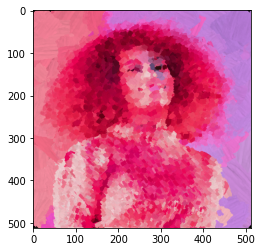

In [20]:
# Save the original corrupted image for later
!cp /content/paint/samples/inputs/darling_cloaked.png /content/fawkes.png

# Shuffle some files in preparation for paint transformer

!rm /content/paint/samples/inputs/darling.jpg

!cp /content/paint/samples/inputs/darling_cloaked.png /content/paint/samples/inputs/darling.jpg

# # Paint the corrupted image
%cd /content/paint
!ls
!python3 inference.py


#Save output for later
!cp /content/paint/samples/outputs/darling/170.png /content/transformer.jpg

from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

img = cv2.imread("/content/paint/samples/outputs/darling/170.png") 

# Show the stylized image
plt.imshow(img)

#Creating a high resolution image
We'll use this high-resolution image to test whether faces can be detected in an upscaled version of the corrupted image.


In [22]:

import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

IMAGE_1_PATH = "/content/fawkes.png"
IMAGE_2_PATH = "/content/transformer.jpg"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(SAVED_MODEL_PATH)


def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

 
# only Fawkes
hr_image_1 = preprocess_image(IMAGE_1_PATH)
fake_image_1 = model(hr_image_1)
fake_image_1 = tf.squeeze(fake_image_1)
save_image(tf.squeeze(fake_image_1), filename="upscaled_fawkes") #upscaled_fawkes.jpg




# Paint Transformer + Fawkes
hr_image_2 = preprocess_image(IMAGE_2_PATH)
fake_image_2 = model(hr_image_2)
fake_image_2 = tf.squeeze(fake_image_2)
save_image(tf.squeeze(fake_image_2), filename="upscaled_paint") #upscaled_paint.jpg





Saved as upscaled_fawkes.jpg
Saved as upscaled_paint.jpg


# Testing our strategy
Now, we test a face detection's model confidence when detecting images perturbed with and without a transformer.

In [23]:
# Testing corrupted image on MTCNN

import cv2
from mtcnn import MTCNN
img_fawkes = cv2.cvtColor(cv2.imread("upscaled_fawkes.jpg"), cv2.COLOR_BGR2RGB)
detector = MTCNN()
fawkes_c = detector.detect_faces(img_fawkes)

print("This is the confidence of MTCNN for Fawkes alone:")
print(fawkes_c)


img_paint = cv2.cvtColor(cv2.imread("upscaled_paint.jpg"), cv2.COLOR_BGR2RGB)
paint_c = detector.detect_faces(img)

print("This is the confidence of MTCNN for Fawkes with the Paint Transformer:")
print(paint_c)



This is the confidence of MTCNN for Fawkes alone:
[{'box': [1609, 859, 1039, 1164], 'confidence': 0.9934871196746826, 'keypoints': {'left_eye': (1916, 1328), 'right_eye': (2401, 1240), 'nose': (2236, 1415), 'mouth_left': (2083, 1776), 'mouth_right': (2463, 1696)}}]
This is the confidence of MTCNN for Fawkes with the Paint Transformer:
[]
